In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from struct import iter_unpack

# Read from binary

In [2]:
def read(path):
    with open(path, 'rb') as f:
        return [x for x in iter_unpack('<Lff', f.read())]

In [3]:
solar   = pd.DataFrame(read('./data/solar'),   columns=['datetime', 'voltage (V)', 'current (mA)'])
battery = pd.DataFrame(read('./data/battery'), columns=['datetime', 'voltage (V)', 'current (mA)'])
solar   = solar[solar['datetime']>0]
battery = battery[battery['datetime']>0]
solar = solar.set_index('datetime')
solar.index = pd.to_datetime(solar.index, unit='s')
solar['power (mW)'] = solar['voltage (V)'] * solar['current (mA)']
battery = battery.set_index('datetime')
battery.index = pd.to_datetime(battery.index, unit='s')
battery['power (mW)'] = battery['voltage (V)'] * battery['current (mA)']

# Read from CSV

In [21]:
# def parse(data):
#     # remove duplicate headers
#     data = data.loc[data['time'] != 'time']
#     # convert to appropriate datatypes
#     data.loc[:,'time'] = pd.to_datetime(data.loc[:,'time'], unit='s', errors='coerce')
#     for c in ['voltage (V)', 'current (mA)']:
#         data.loc[:,c] = pd.to_numeric(data.loc[:,c], errors='coerce')
#     # set index
#     data = data.set_index('time')
#     return data

In [25]:
# battery = parse(pd.read_csv('data/BATTERY_libreoffice.csv', usecols=['time', 'voltage (V)', 'current (mA)']))
# solar = parse(pd.read_csv('data/SOLAR_libreoffice.csv', usecols=['time', 'voltage (V)', 'current (mA)']))

/home/jeroen/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jeroen/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/home/jeroen/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view

In [26]:
# battery['power (mW)'] = battery['voltage (V)'] * battery['current (mA)']
# solar['power (mW)'] = solar['voltage (V)'] * solar['current (mA)']

In [33]:
# battery = battery.loc['2018-03-20':'2018-04-01']
# solar = solar.loc['2018-03-20':'2018-04-01']

# Plot

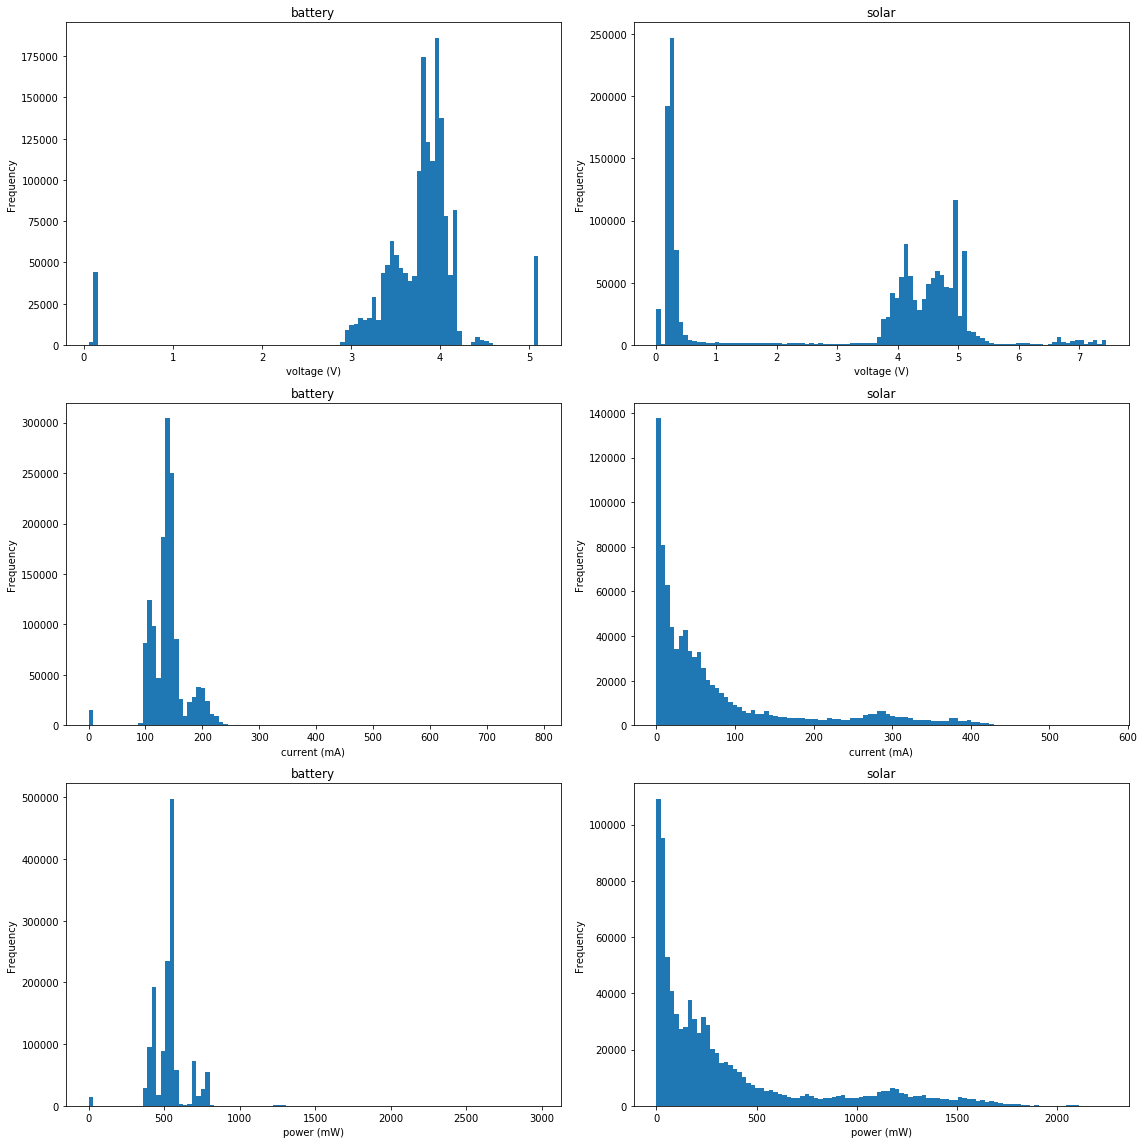

In [13]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16,16))

for i,x in enumerate([battery, solar]):
    for j in range(3):
        axes[j,i].set_title(['battery', 'solar'][i])
    axes[0,i].set_xlabel('voltage (V)')
    axes[1,i].set_xlabel('current (mA)')
    axes[2,i].set_xlabel('power (mW)')
    x.loc[x['voltage (V)']>0, 'voltage (V)'].plot.hist(ax=axes[0,i], bins=100)
    x.loc[x['current (mA)']>0, 'current (mA)'].plot.hist(ax=axes[1,i], bins=100)
    x.loc[x['power (mW)']>0, 'power (mW)'].plot.hist(ax=axes[2,i], bins=100)

plt.tight_layout()
plt.show()

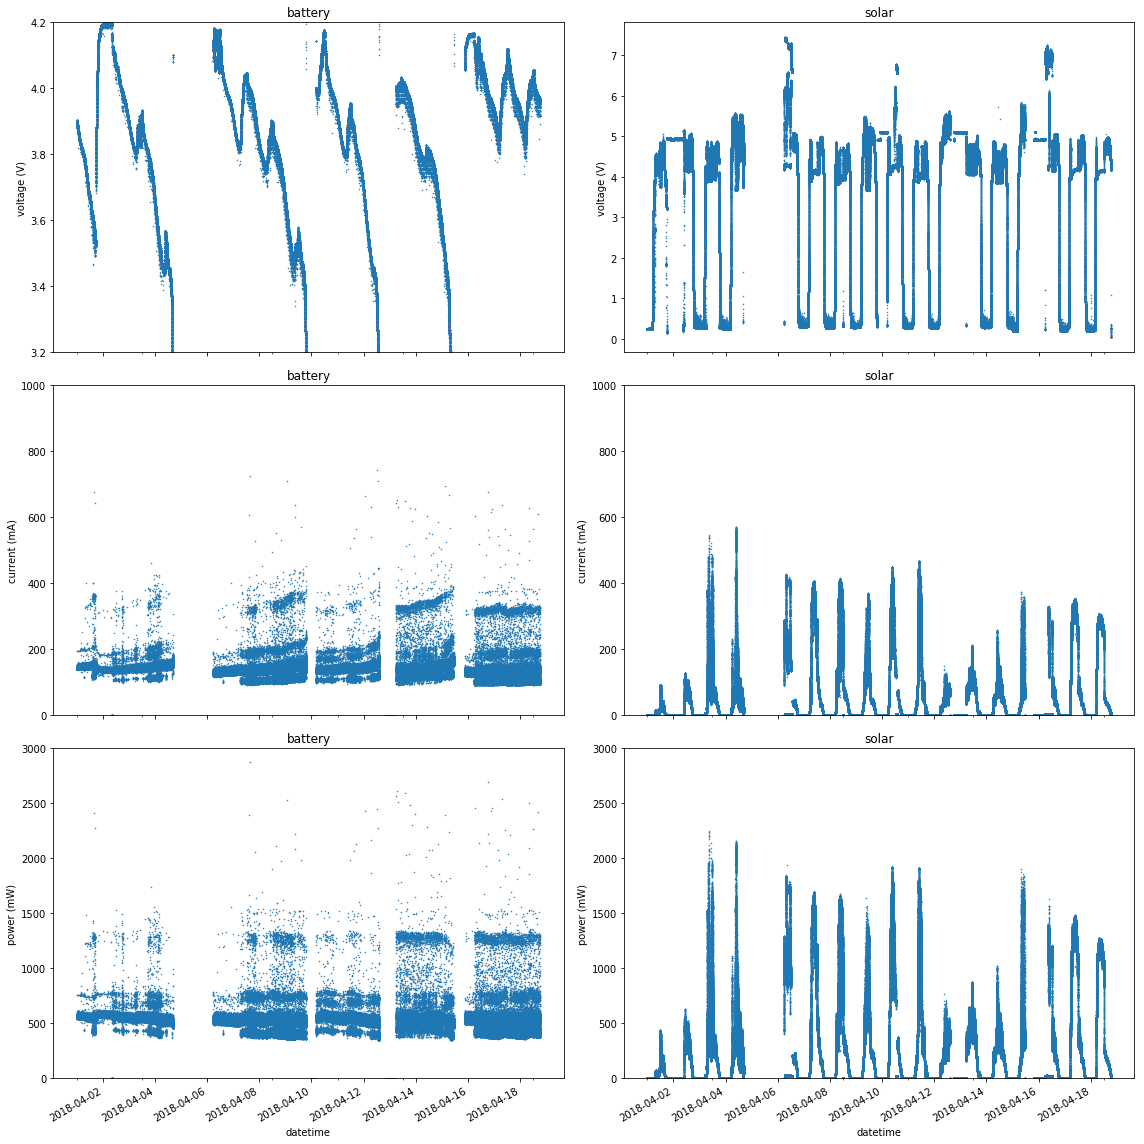

In [14]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(16,16), sharex=True)

for i,x in enumerate([battery, solar]):
    for j in range(3):
        axes[j,i].set_title(['battery', 'solar'][i])
    axes[0,0].set_ylim([3.2,4.2])
    axes[1,i].set_ylim([0,1000])
    axes[2,i].set_ylim([0,3000])
    axes[0,i].set_ylabel('voltage (V)')
    axes[1,i].set_ylabel('current (mA)')
    axes[2,i].set_ylabel('power (mW)')
    x.loc['2018-04-01':, 'voltage (V)'].plot(ax=axes[0,i], style='.', markersize=1)
    x.loc['2018-04-01':, 'current (mA)'].plot(ax=axes[1,i], style='.', markersize=1)
    x.loc['2018-04-01':, 'power (mW)'].plot(ax=axes[2,i], style='.', markersize=1)

plt.tight_layout()
plt.show()

In [28]:
import seaborn as sns

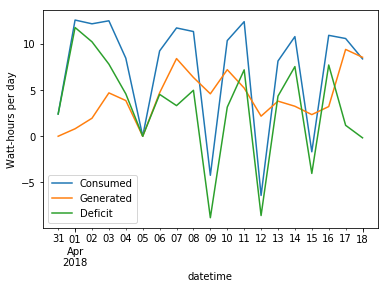

In [58]:
fig, ax = plt.subplots()
ax.set_ylabel('Watt-hours per day')
consumed = battery.loc['2018-03-31':,'power (mW)'].resample('D').sum()/60/60/1000
consumed.plot(ax=ax, label='Consumed')
generated = solar.loc['2018-03-31':,'power (mW)'].resample('D').sum()/60/60/1000
generated.plot(ax=ax, label='Generated')
deficit = consumed - generated
deficit.plot(ax=ax, label='Deficit')
ax.legend()
plt.show()

In [79]:
df = pd.merge(solar, battery, left_index=True, right_index=True, suffixes=(' solar', ' battery'))

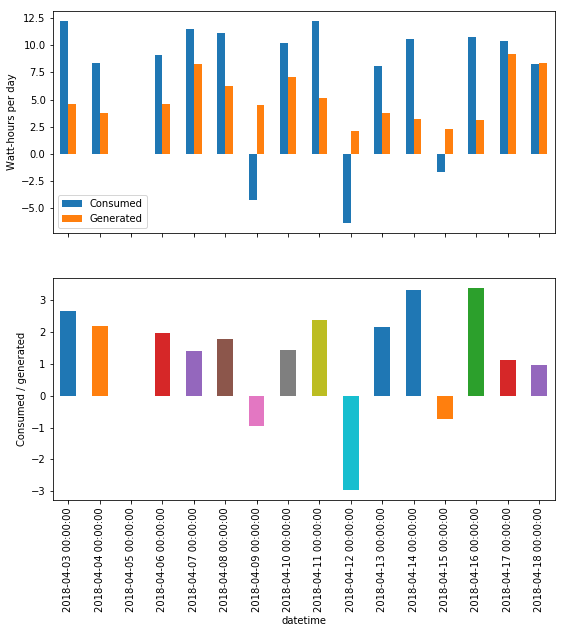

In [87]:
daily = df.resample('D').sum().loc['2018-04-03':,['power (mW) battery', 'power (mW) solar']]/60/60/1000
daily = daily.rename(columns={'power (mW) battery': 'Consumed', 'power (mW) solar': 'Generated'})
fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(9,9))
daily.plot.bar(ax=axes[0])
axes[0].set_ylabel('Watt-hours per day')
(daily['Consumed']/daily['Generated']).plot.bar(ax=axes[1])
axes[1].set_ylabel('Consumed / generated')
plt.show()

In [83]:
(daily['power (mW) battery']/daily['power (mW) solar']).loc['2018-04-14']

3.3212261314259575

Since I moved the solar panel to a better spot (on April 2nd), April 14th was the day with the largest power generation deficit (excluding days with only partial measurements). I needed about 3.3 times more power generation than I had.